In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F


# Load data

In [2]:
training_mnist_data = mnist_data_lib.load_mnist_data()

In [3]:
train_set, test_set = mnist_data_lib.get_mnist_dataset(propn_sample=0.001)

In [4]:
print('num_train: ', train_set.num_images)
print('num_test: ', test_set.num_images)

num_train:  60
num_test:  10


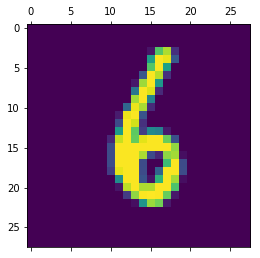

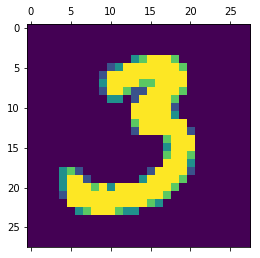

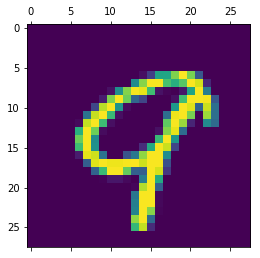

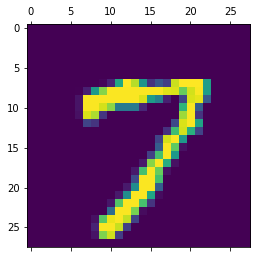

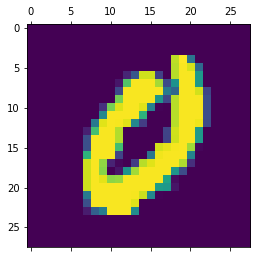

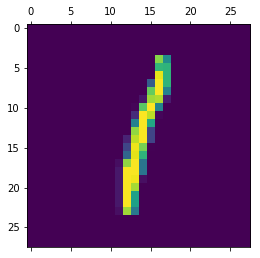

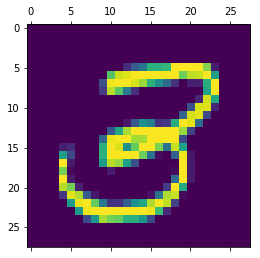

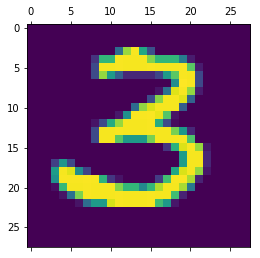

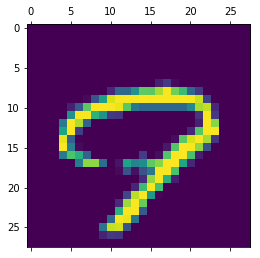

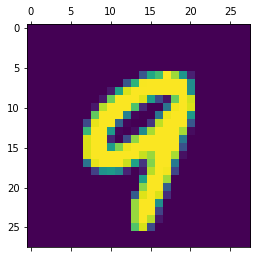

In [5]:
for i in range(10): 
    plt.matshow(train_set[i]['image'].squeeze())

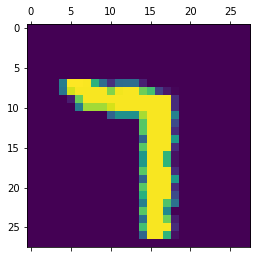

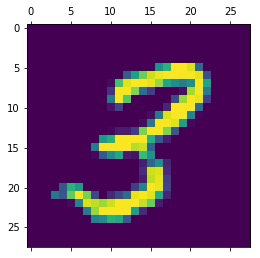

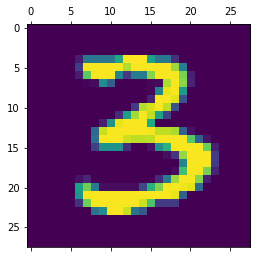

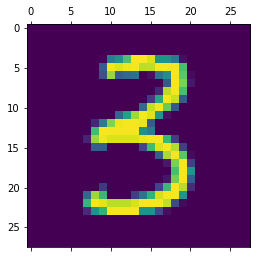

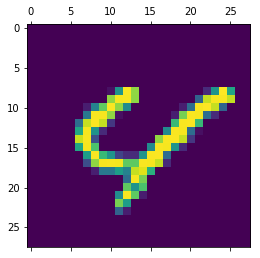

In [6]:
for i in range(5): 
    plt.matshow(test_set[i]['image'].squeeze())

In [7]:
slen = train_set[0]['image'].shape[0]

# Get data loaders

In [8]:
batchsize = 10

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batchsize,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [9]:
for batch_idx, d in enumerate(train_loader):
    data = d
    break

In [10]:
data['image'].shape

torch.Size([10, 28, 28])

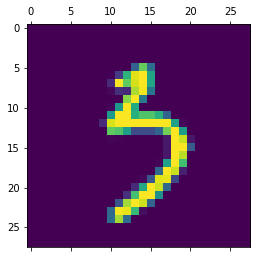

In [11]:
plt.matshow(data['image'][0, :, :])

# Define VAE

In [12]:
latent_dim = 5
n_classes = 10

In [13]:
vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [14]:
print(vae.parameters)

<bound method Module.parameters of HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=784, bias=True)
    (fc5): Linear(in_features=784, out_features=10, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=9, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=15, out_features=784, bias=True)
    (fc2): Linear(in_features=784, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=128, bias=True)
    (fc5): Linear(in_features=128, out_features=1568, bias=True)
  )
)>


In [15]:
28 * 28

784

In [16]:
2 * 28 * 28

1568

In [17]:
### Check things run

In [18]:
data['image'].shape

torch.Size([10, 28, 28])

In [19]:
28 ** 2

784

In [21]:
# check encoder 

class_weights = vae.classifier(data['image'])
assert class_weights.shape[0] == batchsize
assert class_weights.shape[1] == n_classes 

latent_means, latent_std = \
    vae.encoder(data['image'], class_weights)
    
assert latent_means.shape[0] == batchsize
assert latent_means.shape[1] == latent_dim

assert latent_std.shape[0] == batchsize
assert latent_std.shape[1] == latent_dim




In [23]:
z_ind = torch.argmax(class_weights, dim = 1)

In [24]:
z_ind

tensor([ 6,  6,  1,  6,  6,  4,  6,  8,  1,  6])

In [25]:
# check one hot encoding 

one_hot_z = common_utils.get_one_hot_encoding_from_int(z_ind, 10)

seq = torch.Tensor([i for i in range(n_classes)])

for n in range(batchsize): 
    foo = one_hot_z[n, :]
    
    assert foo[z_ind[n]] == 1.
    assert sum(foo) == 1.

In [26]:
image_mean, image_std = vae.decoder(latent_means, one_hot_z)
assert image_mean.shape[0] == batchsize
assert image_mean.shape[1] == slen
assert image_mean.shape[1] == slen

In [27]:
# check loss goes through

In [28]:
vae.loss(data['image'])

(tensor(811.2128),
 tensor([[ 0.0987,  0.0993,  0.0987,  0.0987,  0.0987,  0.0987,  0.1071,
           0.0987,  0.0987,  0.1026],
         [ 0.0986,  0.1052,  0.0986,  0.0986,  0.0986,  0.0986,  0.1058,
           0.0986,  0.0986,  0.0990],
         [ 0.0981,  0.1066,  0.0981,  0.0981,  0.0981,  0.0981,  0.1003,
           0.0981,  0.0981,  0.1064],
         [ 0.0992,  0.0992,  0.0992,  0.0992,  0.0992,  0.0992,  0.1072,
           0.0992,  0.0992,  0.0996],
         [ 0.0990,  0.0993,  0.0990,  0.0990,  0.0990,  0.0990,  0.1089,
           0.0990,  0.0990,  0.0990],
         [ 0.0988,  0.1017,  0.0988,  0.1010,  0.1027,  0.0988,  0.1018,
           0.0988,  0.0988,  0.0988],
         [ 0.0983,  0.1024,  0.0983,  0.0983,  0.0983,  0.0983,  0.1092,
           0.0983,  0.1004,  0.0983],
         [ 0.0967,  0.1002,  0.0967,  0.1071,  0.0967,  0.0967,  0.1009,
           0.0967,  0.1111,  0.0972],
         [ 0.0976,  0.1092,  0.0976,  0.1017,  0.0976,  0.0976,  0.1050,
           0.0976,  

# Check gradient works 

In [29]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [30]:
vae_params0 = get_vae_params(vae)

In [31]:
assert np.any(np.isnan(vae_params0)) == False

In [32]:
optimizer = optim.Adam(vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [33]:
loss = vae.loss(data['image'])[0]
print(loss)

tensor(811.2198)


In [34]:
loss.backward()
optimizer.step()

In [35]:
vae_params1 = get_vae_params(vae)

In [36]:
assert np.any(np.isnan(vae_params1)) == False

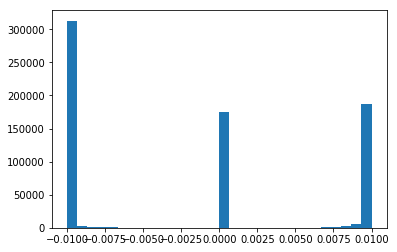

In [37]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [38]:
loss = vae.loss(data['image'])[0]

In [39]:
assert np.isfinite(loss.detach().numpy())

# Test training

In [40]:
from torch.utils.data.sampler import Sampler

In [41]:
vae.train_module(train_loader, test_loader, 
                 n_epoch = 5, 
                print_every = 2, 
                outfile = './test', 
                set_true_class_label = True)

  * init train recon loss: 3847055;
  * init test recon loss: 221178.8281;
[1] loss: 103685.875  	[0.4 seconds]
[2] loss: 706.2243042  	[0.3 seconds]
  * train recon loss: 724.9224243;
  * test recon loss: 723.1478882;
[3] loss: 726.2427979  	[0.3 seconds]
[4] loss: 712.3652954  	[0.3 seconds]
  * train recon loss: 684.842041;
  * test recon loss: 691.3919678;
[5] loss: 636.1870117  	[0.4 seconds]
writing the encoder parameters to ./test_enc_final

writing the decoder parameters to ./test_dec_final



In [42]:
# check reloading

In [43]:
reload_vae = vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [44]:
enc_file = "./test_enc_final"
dec_file = './test_dec_final'

reload_vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

reload_vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))


In [45]:
reload_vae.eval_vae(train_loader)

tensor(575.2518)